## Female vs Male


In [13]:
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
#from keras.preprocessing.image import load_img, ImageDataGenerator
import tensorflow as tf
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn import tree as sktree
import socket
import os
import matplotlib.pyplot as plt
import numpy as np

In [14]:
base_dir = 'Male_and_Female'

train_dir = os.path.join(base_dir, 'Training')

test_dir = os.path.join(base_dir, 'Validation')

In [15]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
def tree(directory, print_files=False):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}|")
        subindent = ' ' * 4 * (level + 1)
        if print_files:
            for file in files:
                print(f"{subindent}{file}")
tree(base_dir,print_files=False)

Male_and_Female|
    Training|
        female|
        male|
    Validation|
        female|
        male|


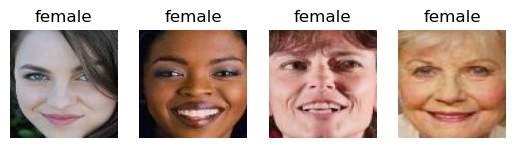

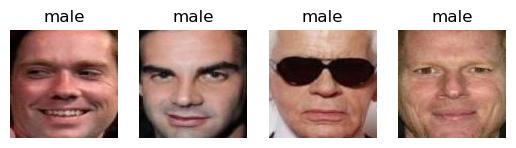

In [16]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
def plot_cats_dogs_samples(directory, N=4):
    for root, dirs, files in os.walk(directory):
        subfolder = os.path.basename(root)
        for i, file in enumerate(files[:N]):
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = load_img(img_path, target_size=(500,500))
                plt.subplot(1,N,i+1)
                plt.imshow(img)
                plt.title(subfolder)
                plt.axis('off')
        plt.show()

plot_cats_dogs_samples(train_dir, N=4)

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, # rescale pixel values between 0 and 1
    rotation_range=40, # rotate images randomly up to 40 degrees
    width_shift_range=0.2, # shift images horizontally up to 20% of the width
    height_shift_range=0.2, # shift images vertically up to 20% of the height
    shear_range=0.2, # shear images by up to 20%
    zoom_range=0.2, # zoom in on images by up to 20%
    horizontal_flip=True, # flip images horizontally
    fill_mode='nearest') # fill in missing pixels with the nearest value)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
#Теперь для создания генератора вместо метода flow мы пользуемся 
# flow_from_directory

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(150, 150),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [19]:
# Соотношение между номером класса и его названием запишем в словарь
LABEL_DICT={1:'male',0:'female'}

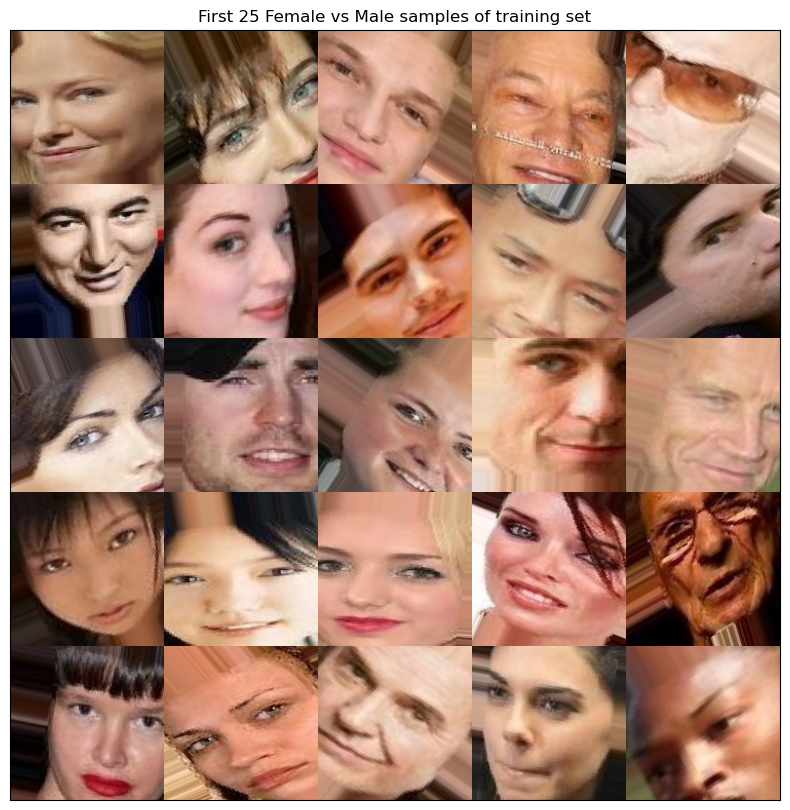

In [20]:
# train_generator является итератором, т.е., чтобы получить батч элементов
# нужно выполнить какую-то итерирующую функцию: например, цикл for
for img in train_generator:
  img=img[0]
  break

#Посмотрим, какие у нас вышли картинки при помощи функции plot_dataset_samples_grid
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN самплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

plot_dataset_samples_grid(img,'Female vs Male', N=5)

In [21]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

#1й сверточный блок
  # Начинаем со сверточных слоев, указывая тип активации ReLU
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))

#2й сверточный блок
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#3й сверточный блок
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(1024, activation='relu'))
  # Sigmoid в качестве активации и одна выходная переменная - 
  # вероятность, что картинка принадлежит к классу 1
  model.add(Dense(1, activation='sigmoid'))


  # Компилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
  return model

In [22]:
# Создаем новую модель
base_model = define_model()

In [23]:
#Посмотрим, из чего наша модель состоит
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
history = base_model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=test_generator)

C:\Users\witho\AppData\Local\Temp\ipykernel_6584\3889777584.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


Epoch 1/10
368/368 [==============================] - 1753s 5s/step - loss: 0.5727 - accuracy: 0.7228 - val_loss: 0.3705 - val_accuracy: 0.8383
Epoch 2/10
368/368 [==============================] - 1696s 5s/step - loss: 0.4128 - accuracy: 0.8164 - val_loss: 0.2410 - val_accuracy: 0.9072
Epoch 3/10
249/368 [===================>..........] - ETA: 7:40 - loss: 0.3163 - accuracy: 0.8687

In [ ]:
history = base_model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=test_generator)

C:\Users\witho\AppData\Local\Temp\ipykernel_12816\3889777584.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


Epoch 1/10
368/368 [==============================] - 2005s 5s/step - loss: 0.1591 - accuracy: 0.9399 - val_loss: 0.1144 - val_accuracy: 0.9585
Epoch 2/10
368/368 [==============================] - 4780s 13s/step - loss: 0.1596 - accuracy: 0.9397 - val_loss: 0.1402 - val_accuracy: 0.9434
Epoch 3/10
368/368 [==============================] - 2205s 6s/step - loss: 0.1542 - accuracy: 0.9429 - val_loss: 0.1199 - val_accuracy: 0.9555
Epoch 4/10
368/368 [==============================] - 2101s 6s/step - loss: 0.1511 - accuracy: 0.9435 - val_loss: 0.1158 - val_accuracy: 0.9584
Epoch 5/10
368/368 [==============================] - 2108s 6s/step - loss: 0.1568 - accuracy: 0.9417 - val_loss: 0.1154 - val_accuracy: 0.9560
Epoch 6/10
368/368 [==============================] - 2151s 6s/step - loss: 0.1548 - accuracy: 0.9426 - val_loss: 0.1433 - val_accuracy: 0.9482
Epoch 7/10
130/368 [=========>....................] - ETA: 20:24 - loss: 0.1546 - accuracy: 0.9412

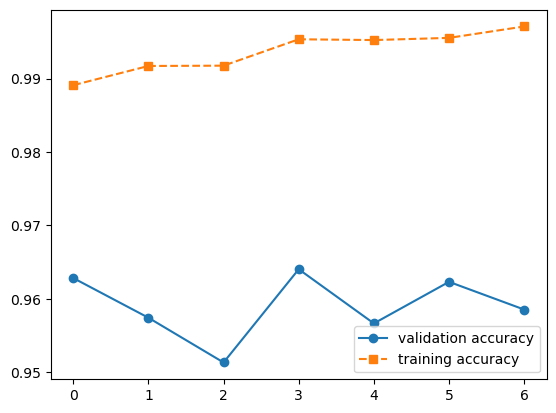

In [18]:
# Построим изменение точности на обучающей (рыжая линия) и тестовой (синяя линия) выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [31]:
base_model.evaluate(test_generator)

92/92 [==============================] - 138s 1s/step - loss: 0.2129 - accuracy: 0.9585


[0.2129410356283188, 0.958537220954895]

In [1]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

base_model = define_model()

# Load an image and preprocess it
img = load_img('C:/Users/witho/Untitled Folder/Courouse/f1.jpg', target_size=(150, 150, 3))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x=x/255.0
#x = preprocess_input(x)

# Make a prediction
pred = base_model.predict(x)
if pred[0][0] > 0.5:
    label = "female"
else:
    label = "male"
# Display the image and the predicted label
plt.imshow(img)
plt.title(label)
plt.show()

NameError: name 'define_model' is not defined